<a href="https://colab.research.google.com/github/101maza010/PINN-and-JAX/blob/main/DiferenciacionAutomatica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18168 sha256=2159c2c2ed8d479bbcedc5f586162ed22b6ff870b83c00f0427fb33f96e44108
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


La diferenciación automática es una técnica fundamental en el campo del cálculo numérico y la optimización, que permite calcular de manera eficiente las derivadas de funciones sin la necesidad de utilizar métodos numéricos tradicionales o simbólicos.

Esta técnica se basa en el concepto de descomponer una función en operaciones elementales y calcular las derivadas locales en cada una de ellas. Las derivadas se propagan a través de la función, permitiendo obtener la derivada global en cualquier punto de interés. Esta técnica es especialmente útil en problemas complejos donde se requiere calcular derivadas de forma eficiente y precisa.


# Autograd

Autograd es una biblioteca popular que implementa la diferenciación automática en el contexto de la programación diferenciable. Permite calcular automáticamente las derivadas de funciones definidas mediante expresiones simbólicas o algoritmos numéricos. Autograd se utiliza ampliamente en el campo del aprendizaje automático y la optimización, ya que simplifica considerablemente el proceso de cálculo de gradientes. Esto último es especialmente útil para aplicaciones como las redes neuronales.

#PINN

Las redes neuronales informadas por la física (PINN por sus siglas en ingles) son modelos que incorporan conocimientos y principios físicos en su arquitectura y entrenamiento. Estas redes aprenden a partir de datos observados y, al mismo tiempo, se guían por las leyes fundamentales de la física para realizar predicciones precisas. Un ejemplo de su aplicación es la simulación de sistemas físicos complejos. Al entrenar una red neuronal informada por la física con datos experimentales y principios físicos conocidos, podemos obtener una representación fiel y eficiente del comportamiento de un sistema físico, lo que facilita la exploración y comprensión de fenómenos complejos.

En el contexto de las PINNs, el uso de autograd simplifica enormemente el proceso de entrenamiento y optimización de redes neuronales. Un ejemplo de su aplicación sería en la resolución de ecuaciones diferenciales parciales (EDP). Mediante la combinación de autograd con PINNs, podemos encontrar soluciones aproximadas a EDPs sin la necesidad de discretizar la región de interés. Esto proporciona un enfoque más eficiente y preciso para la resolución de problemas físicos complejos.

# JAX

JAX es una biblioteca de Python para cálculos numéricos y científicos que combina las ventajas del aprendizaje automático y la computación de alto rendimiento. JAX proporciona herramientas para realizar cálculos eficientes en GPU y CPU, así como una interfaz amigable para la implementación de modelos de aprendizaje automático.

En el contexto de las PINNs, JAX se puede utilizar para acelerar el entrenamiento de redes neuronales informadas por la física y realizar cálculos numéricos complejos de manera eficiente. Un ejemplo sería el uso de JAX para implementar una PINN que resuelva una EDP con alta precisión y rapidez.


## Ejemplo 1: Red neuronal entrenada con ecuación diferencial ordinaria (Ec de Burgues 1D).


La ecuación es $$ \frac{d}{dx}\left( EA \frac{du}{dx} \right) + p = 0 $$

Obtenemos la función $f$ dada por:

$$f=\frac{d}{dx}\left( EA \frac{du}{dx} \right) + p$$

La cual será la función a minimizar por la red neuronal.

Para este ejemplo, pondremos $EA(x) =1$ y $p(x)= sin(x)$.

**Condiciones iniciales:**

$$y(0)=0$$

$$y(2\pi)=0$$


**Solución:**

$$y=sin(x)$$



In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn   # neural networks
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

#default dtype como float32
torch.set_default_dtype(torch.float)


###Modelo
Se usará la POO para crear una clase para la red neuronal.

In [ ]:
#Parametros
steps=10000  #repeticiones en el entrneamiento
lr=1e-2 #learning rate (tasa de  aprendizaje)
layers = np.array([1,50,50,1]) #2 hidden layers
#dimension capas de entrada, escondidas y de salida:
input_dim = 1
hidden_dim = 50
output_dim = 1
min=0
max=2*np.pi
total_points=500
Nu=2  #Número de puntos de entrenamiento (dado que solo tenemos 2 condiciones iniciales, solo hay dos puntos, que son 0 y 2 pi)
Nf=400  #Número de puntos de colocación, es decir, donde se evaluará la Ec. Dif.

def f_BC(x): # Función solución (servirá para hacer la comparación)
  return torch.sin(x)

def p(x): # Parámetro p(x) = sin(x)
  return torch.sin(x)


class FCN(nn.Module):
    ##Neural Network
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network'
        self.model = nn.Sequential(nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim))

    'foward pass'
    def forward(self,x):
        a = self.model(x)
        return a

    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC):
        loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
        return loss_BC

    #Loss PDE
    def lossPDE(self,x_PDE):
        x_PDE.requires_grad=True #Enable differentiation
        f=self.forward(x_PDE)
        f_x=autograd.grad(f,x_PDE,torch.ones([x_PDE.shape[0],1]),retain_graph=True, create_graph=True)[0]
        f_xx=autograd.grad(f_x,x_PDE,torch.ones([x_PDE.shape[0],1]),retain_graph=True, create_graph=True)[0]
        PDE_1 = -1 * p(x_PDE)

        loss_PDE=self.loss_function(f_xx,PDE_1)
        return loss_PDE

    def loss(self,x_BC,x_PDE):
        loss_bc=self.lossBC(x_BC)
        loss_pde=self.lossPDE(x_PDE)
        return loss_bc + loss_pde

###Entrenamiento de la Red Neuronal

In [ ]:
# Obtener datos:
x = torch.linspace(min,max,total_points).view(-1,1) #prepare to NN
y = f_BC(x) #solucion real
# condiciones de frontera:
BC_1=x[0,:]
BC_2=x[-1,:]
x_BC=torch.vstack([BC_1,BC_2]) #unimos los puntos frontera
#puntos de colocacion
x_PDE = torch.linspace(min,max,Nf).view(-1,1)
x_PDE=x_PDE.float() #conversion a float para el mismo dtype

#Create Model
model = FCN(layers)
print(model)
params = list(model.parameters())
optimizer = torch.optim.SGD(model.parameters(),lr=lr) #optimizador

#Training
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC) #mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

FCN(
  (loss_function): MSELoss()
  (model): Sequential(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Tanh()
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
tensor(0.7618, grad_fn=<AddBackward0>)
tensor(0.0604, grad_fn=<AddBackward0>)
tensor(0.0438, grad_fn=<AddBackward0>)
tensor(0.0290, grad_fn=<AddBackward0>)
tensor(0.0176, grad_fn=<AddBackward0>)
tensor(0.0106, grad_fn=<AddBackward0>)
tensor(0.0065, grad_fn=<AddBackward0>)
tensor(0.0041, grad_fn=<AddBackward0>)
tensor(0.0031, grad_fn=<AddBackward0>)
tensor(0.0167, grad_fn=<AddBackward0>)


###Gráficas

tensor(0.0023, grad_fn=<MseLossBackward0>)


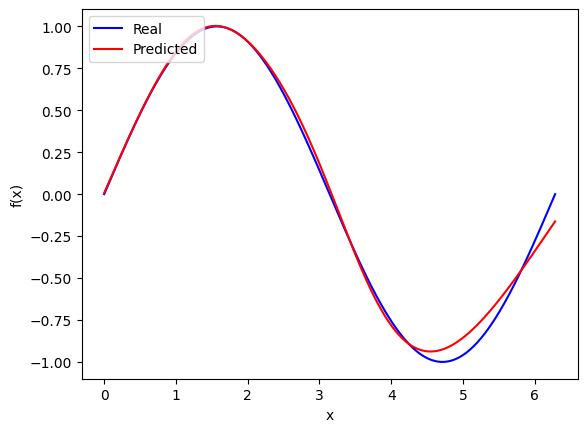

In [ ]:
# Funcion original y modelo
yh=model(x)
y=f_BC(x)
#Error
print(model.lossBC(x))

# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()

# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,color='red',label='Predicted')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## Ejemplo 2. MNIST Dataset con JAX

In [ ]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [ ]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    params = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        params.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return params

# test
key = jax.random.PRNGKey(seed)
MLP_params = init_MLP([784, 512, 256, 10], key)
print(jax.tree_map(lambda x: x.shape, MLP_params))

def MLP_predict(params, x):
    hidden_layers = params[:-1]

    activation = x
    for w, b in hidden_layers:
        activation = jax.nn.relu(jnp.dot(w, activation) + b)

    w_last, b_last = params[-1]
    logits = jnp.dot(w_last, activation) + b_last

    # log(exp(o1)) - log(sum(exp(o1), exp(o2), ..., exp(o10)))
    # log( exp(o1) / sum(...) )
    return logits - logsumexp(logits)

# tests

# test single example

dummy_img_flat = np.random.randn(np.prod(mnist_img_size))
print(dummy_img_flat.shape)

prediction = MLP_predict(MLP_params, dummy_img_flat)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

dummy_imgs_flat = np.random.randn(16, np.prod(mnist_img_size))
print(dummy_imgs_flat.shape)
predictions = batched_MLP_predict(MLP_params, dummy_imgs_flat)
print(predictions.shape)


def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

batch_size = 128
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)


num_epochs = 5

def loss_fn(params, imgs, gt_lbls):
    predictions = batched_MLP_predict(params, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(params, dataset_imgs, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(params, dataset_imgs), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(params, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_fn)(params, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, params, grads)

# Create a MLP
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))

        loss, MLP_params = update(MLP_params, imgs, gt_labels)

        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

imgs, lbls = next(iter(test_loader))
img = imgs[0].reshape(mnist_img_size)
gt_lbl = lbls[0]
print(img.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img)))
print('pred', pred)
print('gt', gt_lbl)

plt.imshow(img); plt.show()

## Ejemplo 3. Ecuaciones de Navier Stokes

Problema conocido como *Driven Cavity*. En él, tendremos que calcular la evolución de un fluido confinado en un dominio cuadrado en el que uno de los lados se mueve.

![](https://www.cfd-online.com/W/images/a/a3/Ldc_geom.png)

En este caso, controlaremos la viscosidad del fluido mediante el `número de Reynolds`, $Re$. Cuanto mayor sea su valor, menor viscosidad tendrá (con todo lo que ello conlleva, principalmente mayor turbulencia e inestabilidades).

$$
\mathbf{u} \cdot \nabla \mathbf{u} = \frac{1}{Re} \nabla^2 \mathbf{u} - \nabla p \\
\nabla \cdot \mathbf{u} = 0
$$

In [ ]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(2, 100),
    Sine(),
    nn.Linear(100, 100),
    Sine(),
    nn.Linear(100, 100),
    Sine(),
    nn.Linear(100, 3)
)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())

def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads


from fastprogress.fastprogress import progress_bar

N_STEPS = 10000
N_SAMPLES = 1000
N_SAMPLES_0 = 1000

optimizer = torch.optim.Adam(mlp.parameters())
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.4*N_STEPS), int(0.8*N_STEPS)], gamma=0.1)
criterion = torch.nn.MSELoss()
mlp.train()
Re = 100
mlp.to(device)

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimize for PDE
    x = torch.rand(N_SAMPLES, device=device)
    y = torch.rand(N_SAMPLES, device=device)

    X = torch.stack([
        x,
        y,
    ], axis=-1)
    X.requires_grad = True

    y_hat = mlp(X)
    u, v, p = y_hat[:,0], y_hat[:,1], y_hat[:,2]

    grads = computeGrads(u, X)
    dudx, dudy = grads[:, 0], grads[:, 1]

    grads = computeGrads(v, X)
    dvdx, dvdy = grads[:, 0], grads[:, 1]

    grads = computeGrads(p, X)
    dpdx, dpdy = grads[:, 0], grads[:, 1]

    du2dx2 = computeGrads(dudx, X)[:, 0]
    du2dy2 = computeGrads(dudy, X)[:, 1]
    dv2dx2 = computeGrads(dvdx, X)[:, 0]
    dv2dy2 = computeGrads(dvdy, X)[:, 1]

    pde_loss = criterion(dudx, - dvdy) + \
        criterion(u*dudx + v*dudy + dpdx, (1./Re)*(du2dx2 + du2dy2)) + \
        criterion(u*dvdx + v*dvdy + dpdy, (1./Re)*(dv2dx2 + dv2dy2))

    # optimize for boundary conditions
    # left
    y = torch.rand(N_SAMPLES_0, device=device)
    Y0 = torch.stack([
        torch.zeros(N_SAMPLES_0, device=device),
        y,
    ], axis=-1)
    Y0.requires_grad = True
    p_y0 = torch.stack([
        torch.zeros(N_SAMPLES_0, device=device),
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y0 = mlp(Y0)
    y0_uv_loss = criterion(y_y0[:,:2], p_y0)
    p = y_y0[:,2]
    dpdx = computeGrads(p, Y0)[:,0]
    y0_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # right
    y = torch.rand(N_SAMPLES_0, device=device)
    Y1 = torch.stack([
        torch.ones(N_SAMPLES_0, device=device),
        y,
    ], axis=-1)
    Y1.requires_grad = True
    p_y1 = torch.stack([
        torch.zeros(N_SAMPLES_0, device=device),
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y1 = mlp(Y1)
    y1_uv_loss = criterion(y_y1[:,:2], p_y1)
    p = y_y1[:,2]
    dpdx = computeGrads(p, Y1)[:,0]
    y1_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # bot
    x = torch.rand(N_SAMPLES_0, device=device)
    X0 = torch.stack([
        x,
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    X0.requires_grad = True
    p_x0 = torch.stack([
        torch.zeros(N_SAMPLES_0, device=device),
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x0 = mlp(X0)
    x0_uv_loss = criterion(y_x0[:,:2], p_x0)
    p = y_x0[:,2]
    dpdy = computeGrads(p, X0)[:,1]
    x0_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))
    # top
    x = torch.rand(N_SAMPLES_0, device=device)
    X1 = torch.stack([
        x,
        torch.ones(N_SAMPLES_0, device=device),
    ], axis=-1)
    X1.requires_grad = True
    p_x1 = torch.stack([
        torch.ones(N_SAMPLES_0, device=device),
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x1 = mlp(X1)
    x1_uv_loss = criterion(y_x1[:,:2], p_x1)
    p = y_x1[:,2]
    dpdy = computeGrads(p, X1)[:,1]
    x1_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))

    bound_loss = y0_uv_loss + y0_p_loss + \
        x1_uv_loss + x1_p_loss + \
        x0_uv_loss + x0_p_loss + \
        y1_uv_loss + y1_p_loss


    # update
    optimizer.zero_grad()
    loss = 10.*bound_loss + pde_loss
    loss.backward()
    optimizer.step()
    scheduler.step()

    mb.comment = f'pde_loss {pde_loss.item():.5f} bound_loss {bound_loss.item():.5f}'

################################################################################

def run_mlp(Nx, Ny):
    x = np.linspace(0,1,Nx)
    y = np.linspace(0,1,Ny)
    X = np.stack(np.meshgrid(x,y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float()
    mlp.eval()
    mlp.cpu()
    with torch.no_grad():
        p = mlp(X)
    return p[:,0].reshape(Ny,Nx), p[:,1].reshape(Ny,Nx), p[:,2].reshape(Ny,Nx), x, y


cuda


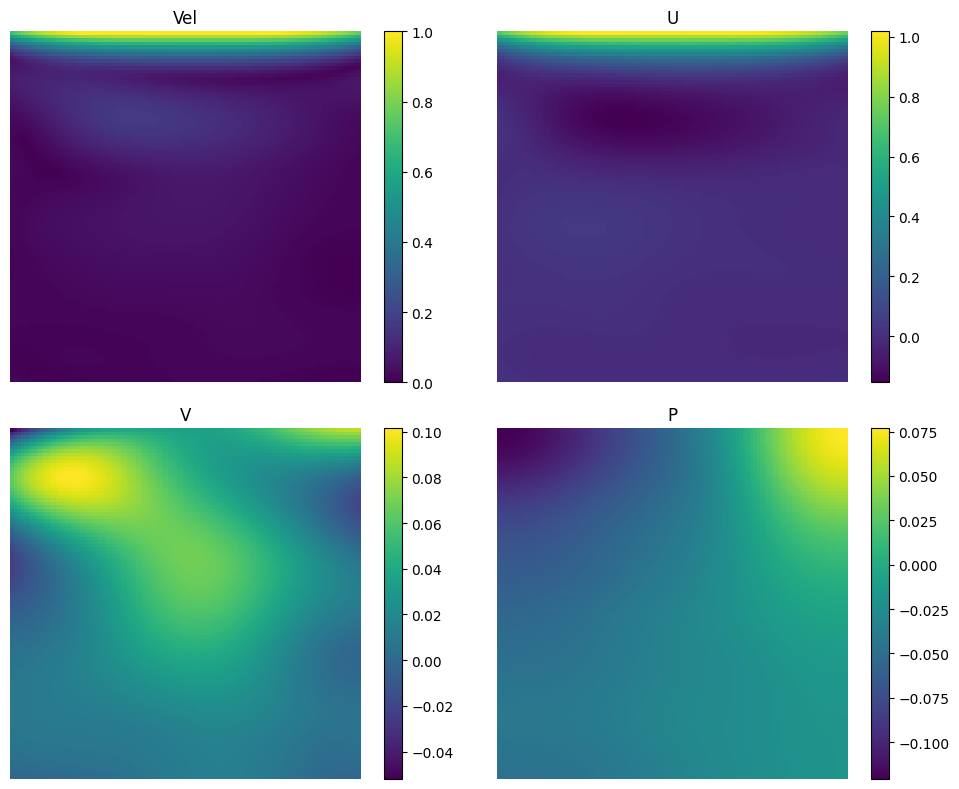

In [ ]:
Nx, Ny = 100, 100
u, v, p, x, y = run_mlp(Nx, Ny)


# plot results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
vel = np.sqrt(u**2 + v**2)
im=ax1.imshow(vel, vmin=0, vmax=1, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("Vel")
ax1.axis(False)
im=ax2.imshow(u, vmin=u.min(), vmax=u.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax2)
ax2.set_title("U")
im=ax3.imshow(v, vmin=v.min(), vmax=v.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax3)
ax2.axis(False)
ax3.axis(False)
ax3.set_title("V")
im=ax4.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax4)
ax4.axis(False)
ax4.set_title("P")
plt.tight_layout()
plt.show()


## Ejemplo 4. Ecuación de difusión

$$\frac{\partial y}{\partial t} =\frac{\partial^2 y}{\partial x^2}-e^{-t}(sin(\pi x)-\pi^2 sin(\pi x))$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

Condición inicial:

$$y(x,0)=sin(\pi x)$$

Condiciones de frontera:

$$y(-1,t)=0$$
$$y(1,t)=0$$

Solución exacta:

$$y(x,t)=e^{-t}sin(\pi x)$$

In [ ]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


#Tuning Parameters
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000

#Aux functions
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

cuda


In [ ]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

#red neuronal
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0 #For the Optimizer
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC,y_BC):
      loss_BC=self.loss_function(self.forward(x_BC),y_BC)
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x_t = autograd.grad(f,g,torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0] #first derivative
      f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph=True)[0]#second derivative
      f_t=f_x_t[:,[1]]# we select the 2nd element for t (the first one is x) (Remember the input X=[x,t])
      f_xx=f_xx_tt[:,[0]]# we select the 1st element for x (the second one is t) (Remember the input X=[x,t])
      f=f_t-f_xx+ torch.exp(-g[:, 1:])* (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
      return self.loss_function(f,f_hat)

    def loss(self,x_BC,y_BC,x_PDE):
      loss_bc=self.lossBC(x_BC,y_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    #Optimizer              X_train_Nu,Y_train_Nu,X_train_Nf
    def closure(self):
      optimizer.zero_grad()
      loss = self.loss(X_train_Nu,Y_train_Nu,X_train_Nf)
      loss.backward()
      self.iter += 1
      if self.iter % 100 == 0:
        loss2=self.lossBC(X_test,Y_test)
        print("Training Error:",loss.detach().cpu().numpy(),"---Testing Error:",loss2.detach().cpu().numpy())
      return loss


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


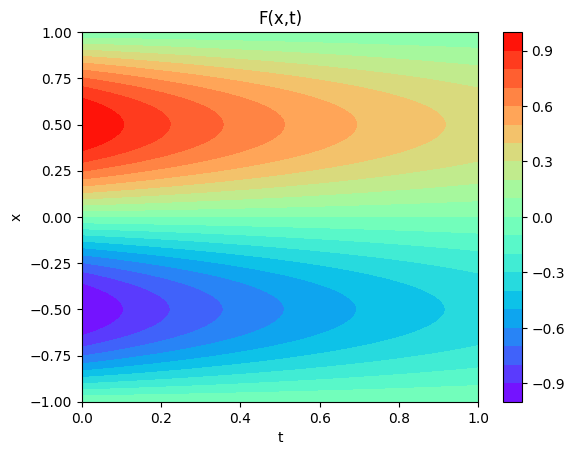

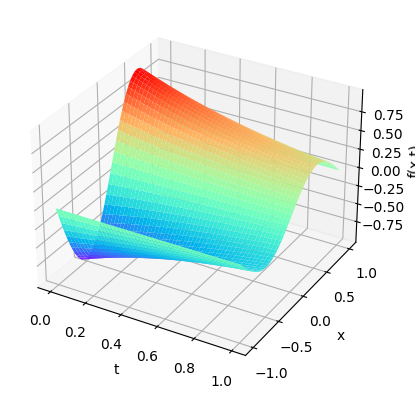

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])
torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])
Original shapes for X and Y: torch.Size([200, 100]) torch.Size([200, 100])
Boundary shapes for the edges: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Available training data: torch.Size([400, 2]) torch.Size([400, 1])
Final training data: torch.Size([100, 2]) torch.Size([100, 1])
Total collocation points: torch.Size([10100, 2])


In [ ]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Create the mesh
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Evaluate real function
y_real=f_real(X,T)
plot3D(x,t,y_real) #f_real was defined previously(function)

print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)

#Preparación de datos
# Transform the mesh into a 2-column vector
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] # Colum major Flatten (so we transpose it)
# Domain bounds
lb=x_test[0] #first value
ub=x_test[-1] #last value
print(x_test.shape,y_test.shape)
print(lb,ub)

################################################################################
#Datos de entrenamiento
#Initial Condition
#Left Edge: x(x,0)=sin(x)->xmin=<x=<xmax; t=0
left_X=torch.hstack((X[:,0][:,None],T[:,0][:,None])) # First column # The [:,None] is to give it the right dimension
left_Y=torch.sin(np.pi*left_X[:,0]).unsqueeze(1)
#Boundary Conditions
#Bottom Edge: x=min; tmin=<t=<max
bottom_X=torch.hstack((X[0,:][:,None],T[0,:][:,None])) # First row # The [:,None] is to give it the right dimension
bottom_Y=torch.zeros(bottom_X.shape[0],1)
#Top Edge: x=max; 0=<t=<1
top_X=torch.hstack((X[-1,:][:,None],T[-1,:][:,None])) # Last row # The [:,None] is to give it the right dimension
top_Y=torch.zeros(top_X.shape[0],1)
#Get all the training data into the same dataset
X_train=torch.vstack([left_X,bottom_X,top_X])
Y_train=torch.vstack([left_Y,bottom_Y,top_Y])
#Choose(Nu) points of our available training data:
idx=np.random.choice(X_train.shape[0],Nu,replace=False)
X_train_Nu=X_train[idx,:]
Y_train_Nu=Y_train[idx,:]
# Collocation Points (Evaluate our PDe)
#Choose(Nf) points(Latin hypercube)
X_train_Nf=lb+(ub-lb)*lhs(2,Nf) # 2 as the inputs are x and t
X_train_Nf=torch.vstack((X_train_Nf,X_train_Nu)) #Add the training poinst to the collocation points

print("Original shapes for X and Y:",X.shape,y_real.shape)
print("Boundary shapes for the edges:",left_X.shape,bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,Y_train.shape)
print("Final training data:",X_train_Nu.shape,Y_train_Nu.shape)
print("Total collocation points:",X_train_Nf.shape)

In [ ]:
torch.manual_seed(123)
#Store tensors to GPU
X_train_Nu=X_train_Nu.float().to(device)#Training Points (BC)
Y_train_Nu=Y_train_Nu.float().to(device)#Training Points (BC)
X_train_Nf=X_train_Nf.float().to(device)#Collocation Points
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)#to minimize function

X_test=x_test.float().to(device) # the input dataset (complete)
Y_test=y_test.float().to(device) # the real solution


#Create Model
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(),lr=lr,amsgrad=False)
'''
'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
                              max_iter = steps,
                              max_eval = None,
                              tolerance_grad = 1e-05,
                              tolerance_change = 1e-09,
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')'''
start_time = time.time()

for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)
Training Loss-----Test Loss
16.872953 --- 0.21578383
0.0023157839 --- 0.04002998
0.00095616456 --- 0.03704937
0.00068439817 --- 0.0362831
0.00022658394 --- 0.03618906
0.00013649528 --- 0.036164038
0.00010106202 --- 0.036120415
0.0011780054 --- 0.03648365
9.8216195e-05 --- 0.03613565
0.0002552015 --- 0.03633658


torch.Size([20000, 1]) torch.Size([20000]) torch.Size([20000])


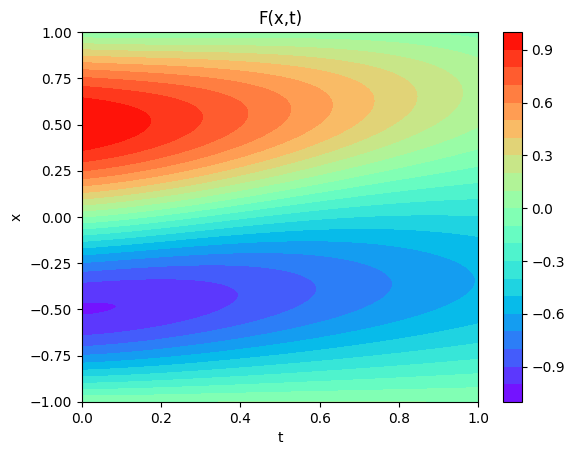

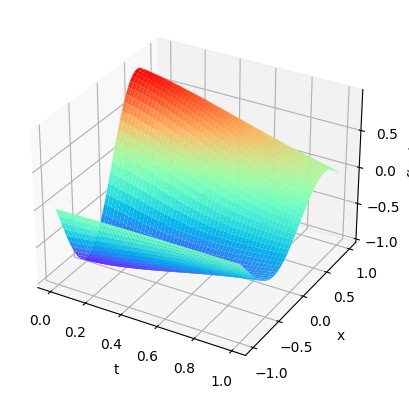

In [ ]:
#Gráficas
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]

print(y1.shape, x1.shape, t1.shape)

arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

plot3D_Matrix(arr_x1,arr_T1,arr_y1)


## Ejemplo 5: Ecuación de Laplace con JAX


La ecuación es $\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = 0$

Obtenemos la función $f$ dada por:

$$f=\frac{d}{dx}\left( EA \frac{du}{dx} \right) + p$$

La cual será la función a minimizar por la red neuronal.

**Condiciones de frontera:**

$p = 0 \text{ en } x=0$ \\
$p = y \text{ en } x=2$

$\frac{\partial p}{\partial y} = 0 \text{ en } \ y=0,1$

<ipython-input-13-94e6111e433e>:82: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
<ipython-input-13-94e6111e433e>:87: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))


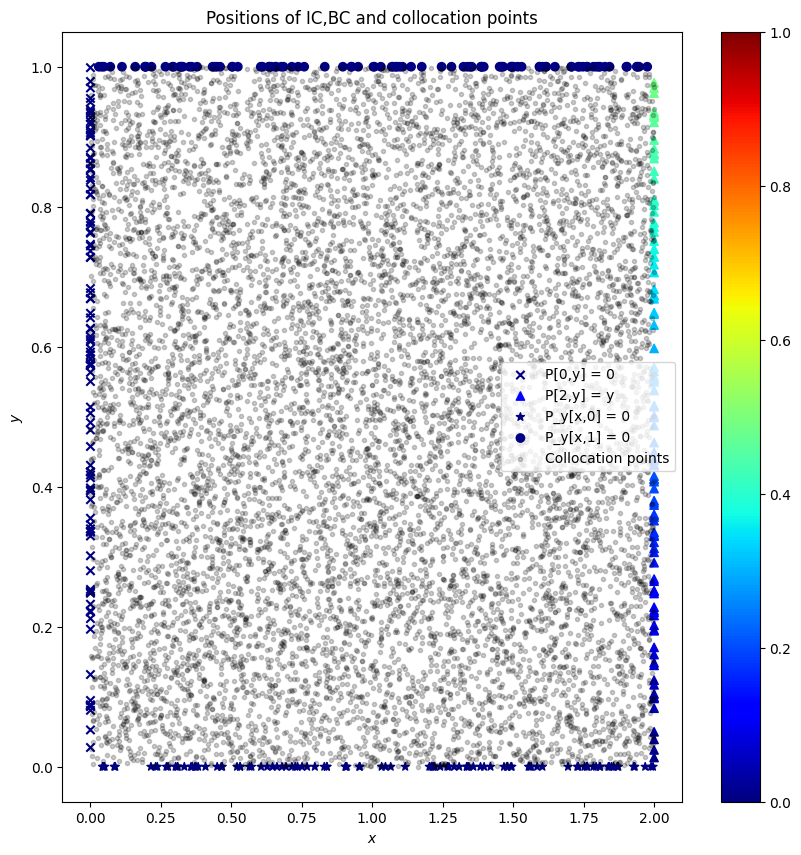

In [ ]:
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax

################################################################################


N_b = 100
N_r = 10_000

ymin,ymax=0. ,1.
xmin,xmax = 0.,2.

'''boundary conditions'''

bk1,bk2,bk3,bk4,r1k,r2k = jax.random.split(jax.random.PRNGKey(0),6)



# P[0,y] = 0
y_b1 = jax.random.uniform(bk1,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b1 = jnp.zeros_like(y_b1)
bc_1 = jnp.zeros_like(y_b1)
BC_1 = jnp.concatenate([x_b1,y_b1,bc_1],axis=1)

# P[2,y] = y
y_b2 = jax.random.uniform(bk2,minval=ymin,maxval=ymax,shape=(N_b,1))
x_b2 = jnp.ones_like(y_b2) *2
bc_2 = y_b2
BC_2 = jnp.concatenate([x_b2,y_b2,bc_2],axis=1)

# P_y[x,0] = 0
x_b3 = jax.random.uniform(bk3,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b3 = jnp.zeros_like(x_b3)
bc_3 = jnp.zeros_like(x_b3)
BC_3 = jnp.concatenate([x_b3,y_b3,bc_3],axis=1)

# P_y[x,1] = 0
x_b4 = jax.random.uniform(bk4,minval=xmin,maxval=xmax,shape=(N_b,1))
y_b4 = jnp.ones_like(x_b4)
bc_4 = jnp.zeros_like(x_b4)
BC_4 = jnp.concatenate([x_b4,y_b4,bc_4],axis=1)

conds = [BC_1,BC_2,BC_3,BC_4]

#collocation points
y_c = jax.random.uniform(r1k,minval=ymin,maxval=ymax,shape=(N_r,1))
x_c = jax.random.uniform(r2k,minval=xmin,maxval=xmax,shape=(N_r,1))
colloc = jnp.concatenate([x_c,y_c],axis=1)

def PDE_loss(x,y,u):
  u_x=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),0)(x,y)
  u_xx=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_x(x,y)),0)(x,y)

  u_y=lambda x,y:jax.grad(lambda x,y:jnp.sum(u(x,y)),1)(x,y)
  u_yy=lambda x,y:jax.grad(lambda x,y:jnp.sum(u_y(x,y)),1)(x,y)

  return u_xx(x,y) + u_yy(x,y)


###############################################################

#grafica de los puntos de colocacion:

fig = plt.figure(figsize=(10,10))
plt.scatter(x_b1, y_b1, c=bc_1, marker='x', vmin=0, vmax=2,label='P[0,y] = 0',cmap=cm.jet)
plt.scatter(x_b2, y_b2, c=bc_2, marker='^', vmin=0, vmax=2,label='P[2,y] = y',cmap=cm.jet)
plt.scatter(x_b3, y_b3, c=bc_3, marker='*', vmin=0, vmax=2,label='P_y[x,0] = 0',cmap=cm.jet)
plt.scatter(x_b4, y_b4, c=bc_4, marker='o', vmin=0, vmax=2,label='P_y[x,1] = 0',cmap=cm.jet)


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1)


plt.scatter(x_c, y_c, c='k', marker='.', alpha=0.2,label='Collocation points',cmap=cm.jet)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.title('Positions of IC,BC and collocation points');
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap))
plt.legend(loc='center right')


#####################################################################

def init_params(layers):
  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()
  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):
    lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in)) # xavier initialization lower and upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))
    B = jax.random.uniform(key,shape=(n_out,))
    params.append({'W':W,'B':B})
  return params

def fwd(params,t,x):
  X = jnp.concatenate([t,x],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


def loss_fun(params,colloc,conds):
  x_c,y_c =colloc[:,[0]],colloc[:,[1]]
  ufunc = lambda x,y : fwd(params,x,y)
  ufunc_y = lambda x,y:jax.grad(lambda x,y:jnp.sum(ufunc(x,y)),1)(x,y)

  loss =jnp.mean(PDE_loss(x_c,y_c,ufunc) **2)

  for cond in conds[0:2] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(ufunc(x_b,y_b),u_b)

  for cond in conds[2:4] :
    x_b,y_b,u_b = cond[:,[0]],cond[:,[1]],cond[:,[2]]
    loss += MSE(ufunc_y(x_b,y_b),u_b)

  return  loss

@jax.jit
def update(opt_state,params,colloc,conds):
  # Get the gradient w.r.t to MLP params
  grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return opt_state,params


#################################################################

# construct the MLP of  6 hidden layers of 20 neurons for each layer
params = init_params([2]+[8]*4+[1])

lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)



In [ ]:
%%time
epochs = 10_000
for _ in range(epochs):
  opt_state,params = update(opt_state,params,colloc,conds)

  # print loss and epoch info
  if _ %(500) ==0:
    print(f'Epoch={_}\tloss={loss_fun(params,colloc,conds):.3e}')

Epoch=0	loss=1.841e-01
Epoch=500	loss=9.440e-03
Epoch=1000	loss=1.557e-03
Epoch=1500	loss=3.702e-03
Epoch=2000	loss=1.555e-03
Epoch=2500	loss=1.238e-03
Epoch=3000	loss=1.142e-03
Epoch=3500	loss=1.601e-03
Epoch=4000	loss=9.803e-04
Epoch=4500	loss=9.377e-04
Epoch=5000	loss=9.431e-04
Epoch=5500	loss=1.001e-03
Epoch=6000	loss=8.780e-04
Epoch=6500	loss=1.073e-03
Epoch=7000	loss=7.793e-04
Epoch=7500	loss=7.484e-04
Epoch=8000	loss=7.257e-04
Epoch=8500	loss=1.364e-03
Epoch=9000	loss=9.446e-04
Epoch=9500	loss=7.531e-04
CPU times: user 3min 4s, sys: 4.91 s, total: 3min 9s
Wall time: 2min 54s


### Numerical solution

In [ ]:
%%time

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import numba
##variable declarations
nx = 101
ny = 101
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

##initial conditions
p = np.zeros((ny, nx))  # create a XxY vector of 0's

##plotting aids
x = np.linspace(0, 2, nx)
y = np.linspace(0, 1, ny)

##boundary conditions
p[:, 0] = 0  # p = 0 @ x = 0
p[:, -1] = y  # p = y @ x = 2
p[0, :] = p[1, :]  # dp/dy = 0 @ y = 0
p[-1, :] = p[-2, :]  # dp/dy = 0 @ y = 1

@numba.jit
def laplace_step(p, y, dx, dy):
    pn = p.copy()
    p[1:-1, 1:-1] = ((dy**2 * (pn[1:-1, 2:] + pn[1:-1, 0:-2]) + dx**2 * (pn[2:, 1:-1] + pn[0:-2, 1:-1])) / (2 * (dx**2 + dy**2)))

    #Boundary condition
    p[:, 0] = 0                 # p[y,0] = 0                   p = 0 @ x = 0
    p[:, -1] = y                # p[y,2] = y                   p = y @ x = 2
    p[0, :] = p[1, :]           # p_y[0,x] = 0                 dp/dy = 0 @ y = 0
    p[-1, :] = p[-2, :]         # p_y[1,x] = 0                 dp/dy = 0 @ y = 1

    norm = (np.sum(np.abs(p[:]) -np.abs(pn[:])) /np.sum(np.abs(pn[:])))

    return p,norm

norm = 1
step = 0
while norm> 1e-4:
  p,norm = laplace_step(p,y,dx,dy)
  step+=1
  if step %100 == 0:
    print(f'step={step}\tl1norm={norm:.3e}')


##############################################################################


def plot2D(T,X, p):
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, p[:],  cmap=cm.viridis)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.view_init(30,225)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

N=100
X,Y = np.meshgrid(x, y)
pred = (fwd(params,X.flatten().reshape(-1,1),Y.flatten().reshape(-1,1))).reshape(N+1,N+1)

<timed exec>:26: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


step=100	l1norm=4.592e-03
step=200	l1norm=2.352e-03
step=300	l1norm=1.586e-03
step=400	l1norm=1.197e-03
step=500	l1norm=9.619e-04
step=600	l1norm=8.042e-04
step=700	l1norm=6.911e-04
step=800	l1norm=6.060e-04
step=900	l1norm=5.396e-04
step=1000	l1norm=4.863e-04
step=1100	l1norm=4.426e-04
step=1200	l1norm=4.061e-04
step=1300	l1norm=3.751e-04
step=1400	l1norm=3.484e-04
step=1500	l1norm=3.251e-04
step=1600	l1norm=3.046e-04
step=1700	l1norm=2.864e-04
step=1800	l1norm=2.701e-04
step=1900	l1norm=2.554e-04
step=2000	l1norm=2.421e-04
step=2100	l1norm=2.299e-04
step=2200	l1norm=2.187e-04
step=2300	l1norm=2.084e-04
step=2400	l1norm=1.988e-04
step=2500	l1norm=1.900e-04
step=2600	l1norm=1.817e-04
step=2700	l1norm=1.740e-04
step=2800	l1norm=1.667e-04
step=2900	l1norm=1.599e-04
step=3000	l1norm=1.535e-04
step=3100	l1norm=1.474e-04
step=3200	l1norm=1.417e-04
step=3300	l1norm=1.363e-04
step=3400	l1norm=1.312e-04
step=3500	l1norm=1.263e-04
step=3600	l1norm=1.217e-04
step=3700	l1norm=1.173e-04
step=3800	

### Plot for Numerical solution

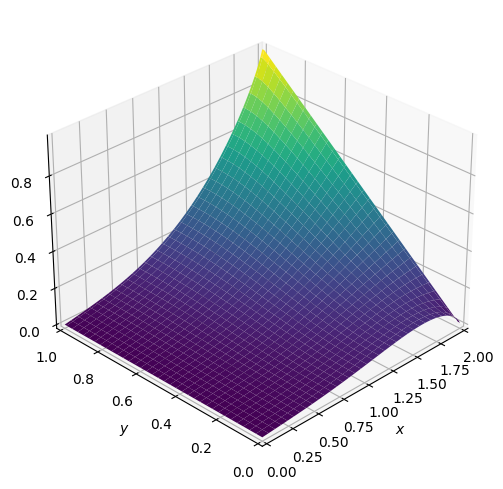

In [ ]:
#numerical
plot2D(X,Y,p)

### Plot for PINN solution

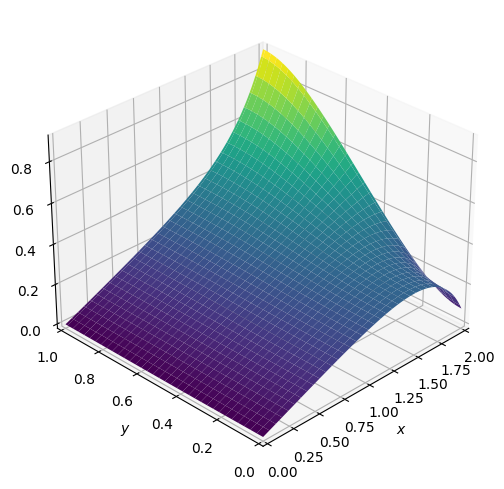

In [ ]:
#prediction
plot2D(X,Y,pred)
